In [2]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import seaborn as sns
from sklearn.metrics import roc_curve, auc
import collections
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
def get_new_features(df):
    df['send_hour'] = df['send_date'].apply(lambda x: int(x[-5:-3]))
    df['send_hour_category'] = pd.cut(df['send_hour'], range(0, 30, 6), labels=['EM', 'M', 'AN', 'N'])
    df['weekday_type'] = df['send_date'].apply(
        lambda x: datetime.datetime.strptime(x[:10], '%d-%m-%Y').date().isoweekday())
    df['has_hackathon'] = df['subject'].apply(lambda x: ('Hack' in x) or ('hack' in x))
    return df

In [4]:
# Pre-processing the data
# Extract hour and weekday on which email was sent as category
# Transforming categorical variables to OHE
def pre_process(df):
    df['send_hour'] = LabelEncoder().fit_transform(df['send_hour'])
    df['send_hour_category'] = LabelEncoder().fit_transform(df['send_hour_category'])
    df['communication_type'] = LabelEncoder().fit_transform(df['communication_type'])
    df['weekday_type'] = LabelEncoder().fit_transform(df['weekday_type'])
    return df

In [5]:
# Loading the data
train = pd.read_csv('train.csv')
dfCampaign = pd.read_csv('campaign_data.csv')
test = pd.read_csv('test.csv')

In [6]:
# Join data frames to get campaign information along with the open/click value
dfTrain = train.join(dfCampaign.set_index('campaign_id'),on='campaign_id')
dfTest =  test.join(dfCampaign.set_index('campaign_id'),on='campaign_id')

In [7]:
print(dfTrain.columns)

Index(['id', 'user_id', 'campaign_id', 'send_date', 'is_open', 'is_click',
       'communication_type', 'total_links', 'no_of_internal_links',
       'no_of_images', 'no_of_sections', 'email_body', 'subject', 'email_url'],
      dtype='object')


In [9]:
# Engineer features
dfTrain = get_new_features(dfTrain)
dfTest = get_new_features(dfTest)

# Viewing open/click probabilities based on communication type

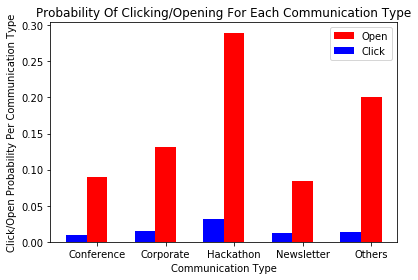

In [14]:
barwidth = .3

ctype_click_pivot = dfTrain.pivot_table(values='is_click',index=['communication_type'],aggfunc=('mean','count','sum')).head()
ctype_open_pivot = dfTrain.pivot_table(values='is_open',index=['communication_type'],aggfunc=('mean','count','sum')).head()
index = np.arange(len(ctype_click_pivot.index))

plt.bar(index+barwidth,ctype_open_pivot['mean'],barwidth,color='r',label='Open')
plt.bar(index,ctype_click_pivot['mean'],barwidth,color='b',label='Click')

plt.ylabel('Click/Open Probability Per Communication Type')
plt.xlabel('Communication Type')
plt.title('Probability Of Clicking/Opening For Each Communication Type')
plt.xticks(index+barwidth,ctype_click_pivot.index)
plt.legend()
plt.tight_layout()

#plt.savefig('CType_vs_Prob.png')


# Viewing open/click probabilities based on send hour


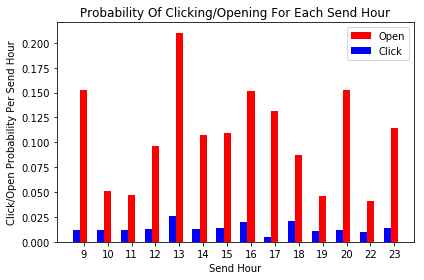

In [15]:
hour_click_pivot = dfTrain.pivot_table(values='is_click',index=['send_hour'],aggfunc=('mean','count','sum'))
hour_open_pivot = dfTrain.pivot_table(values='is_open',index=['send_hour'],aggfunc=('mean','count','sum'))
index = np.arange(len(hour_click_pivot.index))

plt.bar(index+barwidth,hour_open_pivot['mean'],barwidth,color='r',label='Open')
plt.bar(index,hour_click_pivot['mean'],barwidth,color='b',label='Click')

plt.ylabel('Click/Open Probability Per Send Hour')
plt.xlabel('Send Hour')
plt.title('Probability Of Clicking/Opening For Each Send Hour')
plt.xticks(index+barwidth,hour_click_pivot.index)
plt.legend()
plt.tight_layout()
#plt.savefig('SendHour_vs_Prob.png')

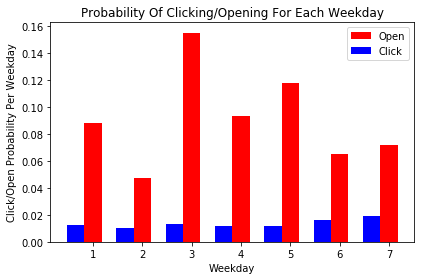

In [17]:
# Viewing open/click probabilities based on day of the week
barwidth = 0.35
wd_click_pivot = dfTrain.pivot_table(values='is_click',index=['weekday_type'],aggfunc=('mean','count','sum'))
wd_open_pivot = dfTrain.pivot_table(values='is_open',index=['weekday_type'],aggfunc=('mean','count','sum'))
index = np.arange(len(wd_click_pivot.index))

plt.bar(index+barwidth,wd_open_pivot['mean'],barwidth,color='r',label='Open')
plt.bar(index,wd_click_pivot['mean'],barwidth,color='b',label='Click')

plt.ylabel('Click/Open Probability Per Weekday')
plt.xlabel('Weekday')
plt.title('Probability Of Clicking/Opening For Each Weekday')
plt.xticks(index+barwidth,wd_click_pivot.index)
plt.legend()
plt.tight_layout()
#plt.savefig('WeekdayType_vs_Prob.png')


In [18]:
# Pre-process Train and Test data by converting to OHE
dfTrain = pre_process(dfTrain)
dfTest = pre_process(dfTest)

# Add fake values to dfTest to get a combined data frame of Train and Test

In [19]:
dfTest['is_click'] = 0
dfTest['is_open'] = 0
dfCombined = pd.concat([dfTrain,dfTest])

## Splitting for CV
### Used while doing cross-validation


In [20]:
trainData,valData,trainLabels,valLabels = train_test_split(dfTrain,dfTrain[['is_click','is_open']])

### Extract click probability and open probability for each UserID


In [21]:
clickProb = dfTrain.pivot_table(values='is_click',index=['user_id'],aggfunc=('mean','sum','count'))
openProb = dfTrain.pivot_table(values='is_open',index=['user_id'],aggfunc=('mean','sum','count'))

### Extract click probability and open probability for each UserID indexed by Communucation Type


In [22]:
typeOpenProb = dfTrain.pivot_table(values='is_open',index=['communication_type'],aggfunc=('mean','sum','count'))
typeClickProb = dfTrain.pivot_table(values='is_click',index=['communication_type'],aggfunc=('mean','sum','count'))

### Get probability of each campaign of being sent using the combined train and test data


In [23]:
campaignTrainProb = dfCombined['campaign_id'].value_counts() / len(dfCombined.index)

### Get probability of each campaign given that user has clicked from Train data


In [24]:
campaignTrainProbGivenClick = dfTrain[dfTrain['is_click'] == 1]['campaign_id'].value_counts() / len(dfTrain[dfTrain['is_click'] == 1].index)

### Get probability of campaign indexed by Communication Type


In [25]:
campaignTrainProbType = dfCombined['communication_type'].value_counts() / len(dfTrain.index)

###  Get probability of each campaign given that user has clicked from Train data per UserID


In [26]:
campaignGivenClickPerUser = dfTrain.pivot_table(values='is_click',index='user_id',columns=['campaign_id'],aggfunc='mean')

### Get probability of Campaign features from train data given that user has clicked

In [28]:
totalClicks = len(dfTrain[dfTrain['is_click'] == 1])
ccIL = dfTrain[dfTrain['is_click'] == 1]['no_of_internal_links'].value_counts() / totalClicks
ccNS = dfTrain[dfTrain['is_click'] == 1]['no_of_sections'].value_counts() / totalClicks
ccNI = dfTrain[dfTrain['is_click'] == 1]['no_of_images'].value_counts() / totalClicks
ccTL = dfTrain[dfTrain['is_click'] == 1]['total_links'].value_counts() / totalClicks
ccCT = dfTrain[dfTrain['is_click']==1]['communication_type'].value_counts() / totalClicks

# Naive Bayes Estimates
# Calculate probability from above calculated data frames if available else use communication type based or overall mean as a proxy

In [29]:
def NBEstimate_1(x):
    global campaignTrainProb
    global trainData
    global campaignTrainProbType
    global campaignGivenClickPerUser
    global campaignTrainProbGivenClick
    global clickProb
    global typeClickProb

    pCampaign = campaignTrainProb[x['campaign_id']]
    pClick = 0.0
    if x['user_id'] in clickProb.index:
        pClick = clickProb.get_value(x['user_id'],col='mean')
    elif x['communication_type'] in typeClickProb.index:
       pClick = typeClickProb.get_value(x['communication_type'],col='mean')
    else: pClick = 0.0

    pCC = 1.0
    if x['user_id'] not in clickProb.index:
        pCC = campaignTrainProbGivenClick[x['campaign_id']]
    else:
        temp = campaignGivenClickPerUser.get_value(x['user_id'],col=x['campaign_id'])
        if np.isnan(temp):
            pCC = campaignTrainProbGivenClick[x['campaign_id']]
        else:
            pCC = temp
    return (pCC*pClick)/pCampaign

In [30]:
def NBEstimate_2(x):
    global campaignTrainProb
    global trainData
    global campaignTrainProbType
    global campaignGivenClickPerUser
    global campaignTrainProbGivenClick
    global clickProb
    global typeClickProb
    global ccIL, ccNS, ccNI, ccTL, ccCT

    pCampaign = campaignTrainProb[x['campaign_id']]
    pClick = 0.0
    if x['user_id'] in clickProb.index:
        pClick = clickProb.get_value(x['user_id'],col='mean')
    elif x['communication_type'] in typeClickProb.index:
       pClick = typeClickProb.get_value(x['communication_type'],col='mean')
    else: pClick = 0.0

    pCC = 1.0
    pCC = pCC *  (ccIL.get_value(x['no_of_internal_links']) if  x['no_of_internal_links'] in ccIL.index else ccIL.mean())
    pCC = pCC * (ccNI.get_value(x['no_of_images']) if x['no_of_images'] in ccNI.index else ccNI.mean())
    pCC = pCC * (ccNS.get_value(x['no_of_sections']) if x['no_of_sections'] in ccNS.index else ccNS.mean())
    pCC = pCC * (ccTL.get_value(x['total_links']) if x['total_links'] in ccTL.index else ccTL.mean())
    pCC = pCC * (ccCT.get_value(x['communication_type']) if x['communication_type'] in ccCT.index else ccCT.mean())
    return (pCC*pClick)/pCampaign


# Click Probability for each UserID
# Use mean click probability for a particular communication type in case of new UserID

In [31]:
def cpEstimate(x):
    global clickProb
    global typeClickProb
    if x['user_id'] in clickProb.index:
        return clickProb.get_value(x['user_id'],col='mean')
    if x['communication_type'] in typeClickProb.index:
       return typeClickProb.get_value(x['communication_type'],col='mean')
    return 0.0

# Use mean open probability for a particular communication type in case of new UserID


In [33]:
def opEstimate(x):
    global openProb
    global typeOpenProb
    if x['user_id'] in openProb.index:
        return openProb.get_value(x['user_id'],col='mean')
    if x['communication_type'] in typeOpenProb.index:
       return typeOpenProb.get_value(x['communication_type'],col='mean')
    return 0.0

In [34]:
# Calculate open and click probabilities on train and test data
dfTrain['cp'] = dfTrain.apply(cpEstimate,axis=1)
dfTrain['op'] = dfTrain.apply(opEstimate,axis=1)
dfTest['cp'] = dfTest.apply(cpEstimate,axis=1)
dfTest['op'] = dfTest.apply(opEstimate,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [35]:
# Naive Bayes Predictions
dfTest['predictionNB'] = dfTest.apply(NBEstimate_2,axis=1)
dfTrain['predictionNB'] = dfTrain.apply(NBEstimate_2,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\li

In [36]:
# Logistic Regression Based on Open and Click Probability values and the NB estimate (Stacking)
model = LogisticRegression(class_weight={0:1,1:100},max_iter=100)
outcome = 'is_click'
predictors = ['op','cp','predictionNB']
modelFit =  model.fit(dfTrain[predictors],dfTrain[outcome])
prediction = model.predict_proba(dfTest[predictors])
dfTest['predictionLR1'] = prediction[:,1]

predictors = ['op','cp']
modelFit =  model.fit(dfTrain[predictors],dfTrain[outcome])
prediction = model.predict_proba(dfTest[predictors])
dfTest['predictionLR2'] = prediction[:,1]

predictors = ['predictionNB','cp']
modelFit =  model.fit(dfTrain[predictors],dfTrain[outcome])
prediction = model.predict_proba(dfTest[predictors])
dfTest['predictionLR3'] = prediction[:,1]

In [37]:
# fpr,tpr,_ = roc_curve(valLabels['is_click'],valData['predictionNB'])
# print(auc(fpr,tpr))

# Weight average ensemble of Naive Bayes and Logistic Regression methods
dfTest['is_click'] = (0.4*dfTest['predictionLR1'] + 0.4*dfTest['predictionLR2'] + 0.1*dfTest['predictionLR3']
                      + 0.1*dfTest['predictionNB'])
#(0.3*dfTest['predictionNB']+0.7*dfTest['predictionLR'])
dfTest[['id','is_click']].to_csv('FinalSubmission.csv',index=False)